In [ ]:
!pip install tensorflow-text

In [ ]:
from tensorflow.keras.preprocessing.text import one_hot
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import tensorflow as tf

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Dataset/spam.csv')

In [ ]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df=df.drop_duplicates()

In [ ]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4516   4516  Go until jurong point, crazy.. Available only ...   
spam         641    641  Free entry in 2 a wkly comp to win FA Cup fina...   

               
         freq  
Category       
ham         1  
spam        1

In [ ]:
641*100/4516

14.193976970770594

**SO 14.2 Emails are spam and rest is ham that means there's data imbalance**

**So we will use Downsampling where ham data sample will be equal to the spam data samples by random sampling**

In [ ]:
df_spam = df[df['Category']=='spam']
print(df_spam.shape)

df_ham = df[df['Category']=='ham']
print(df_ham.shape)


df_ham_downsampled = df_ham.sample(df_spam.shape[0])
print(df_ham_downsampled.shape)

(641, 2)
(4516, 2)
(641, 2)


In [ ]:
df=pd.concat([df_ham_downsampled, df_spam])

In [ ]:
df['spam']=df['Category'].apply(lambda x: 1 if x=='spam' else 0)
df.sample(5)

,Category,Message,spam
5452,ham,What???? Hello wats talks email address?,0
4725,spam,FREE GAME. Get Rayman Golf 4 FREE from the O2 ...,1
950,ham,Is that what time you want me to come?,0
3230,spam,Ur cash-balance is currently 500 pounds - to m...,1
1366,spam,HOT LIVE FANTASIES call now 08707509020 Just 2...,1


In [ ]:
df['spam'].unique()

array([0, 1])

In [ ]:
df.reset_index()

,index,Category,Message,spam
0,137,ham,He is there. You call and meet him,0
1,1806,ham,God bless.get good sleep my dear...i will pray!,0
2,2434,ham,Indians r poor but India is not a poor country...,0
3,2868,ham,"Mum, i've sent you many many messages since i ...",0
4,1360,ham,&lt;#&gt; %of pple marry with their lovers... ...,0
...,...,...,...,...
1277,5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...,1
1278,5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,1
1279,5547,spam,Had your contract mobile 11 Mnths? Latest Moto...,1
1280,5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# Strtaify is used to distribute both types of Samples equaly
X_train, X_test, y_train, y_test = train_test_split(df['Message'],df['spam'], stratify=df['spam'])
X_train.head(4)

1184               Am i that much bad to avoid like this?
335     Valentines Day Special! Win over £1000 in our ...
3711                ARE YOU IN TOWN? THIS IS V. IMPORTANT
4640    Of course. I guess god's just got me on hold r...
Name: Message, dtype: object

# 1.) Functional API Neural Network

## Loading Distill BERT

In [ ]:
# Input layer for text data
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)

# BERT preprocessor layer (distilBERT)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    name="bert_preprocessor"
)
encoder_inputs = preprocessor(text_input)

# Smaller BERT encoder layer (distilBERT)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1",
    trainable=True,
    name="bert_encoder"
)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]

## Building the Neural Network

In [ ]:
dense_units = 64
dense_layer = tf.keras.layers.Dense(dense_units, activation='relu')(pooled_output)

# Output layer
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dense_layer)

# Create the model
model = tf.keras.Model(inputs=text_input, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 5
batch_size = 32
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

# Evaluate the model
accuracy = model.evaluate(X_test, y_test)[1]
print(f"Accuracy: {accuracy}")

Epoch 1/5
27/27 [==============================] - 22s 576ms/step - loss: 0.1932 - accuracy: 0.9167 - val_loss: 0.1475 - val_accuracy: 0.9381
Epoch 2/5
27/27 [==============================] - 15s 562ms/step - loss: 0.0255 - accuracy: 0.9931 - val_loss: 0.2836 - val_accuracy: 0.9485
Epoch 3/5
27/27 [==============================] - 15s 567ms/step - loss: 0.0212 - accuracy: 0.9942 - val_loss: 0.2319 - val_accuracy: 0.9381
Epoch 4/5
27/27 [==============================] - 15s 555ms/step - loss: 0.0247 - accuracy: 0.9919 - val_loss: 0.3321 - val_accuracy: 0.9278
Epoch 5/5
11/11 [==============================] - 1s 121ms/step - loss: 0.1398 - accuracy: 0.9657
Accuracy: 0.9657320976257324


11/11 [==============================] - 1s 118ms/step


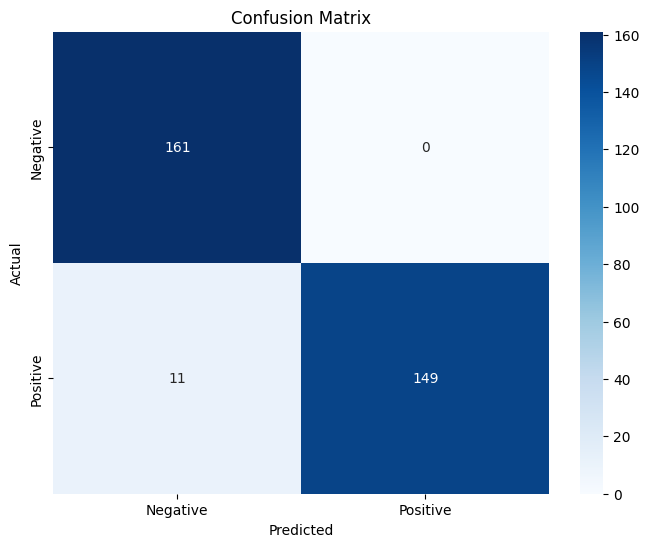

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       161
           1       1.00      0.93      0.96       160

    accuracy                           0.97       321
   macro avg       0.97      0.97      0.97       321
weighted avg       0.97      0.97      0.97       321


Metrics:
Accuracy: 0.9657
Precision: 1.0000
Recall: 0.9313
F1 Score: 0.9644


In [ ]:
import numpy as np

# Display confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
# Calculate accuracy, precision, recall, and F1-score
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
f1_score = 2 * (precision * recall) / (precision + recall)

# Display metrics
print("\nMetrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")